# **SEGUNDO PARCIAL DE SIS420**

## Nombre: Gonzales Suyo Franz Reinaldo
## C.U. 35-5335
## Carrera: Ing. Sistemas

### 2. Desarrolle un cuadernillo aplicando aprendizaje por refuerzo, para que un agente pueda jugar cuatro en raya.

# **APRENDIZAJE POR REFUERZO**

## Ejemplo de Aplicación: Cuatro en Raya.

## Descripción del Juego Cuatro en Raya

## Objetivo

El objetivo del juego Cuatro en Raya es ser el primer jugador en formar una línea continua de cuatro fichas del mismo color en un tablero vertical. La línea puede ser horizontal, vertical o diagonal.

### Componentes

**- Tablero**: Un tablero vertical de 6 filas por 7 columnas.

**- Fichas**: Fichas de dos colores diferentes, típicamente rojo y amarillo. Cada jugador tiene un conjunto de fichas de un solo color.

### Reglas del Juego

**Preparación**:

- El tablero se coloca en posición vertical entre los dos jugadores.

- Cada jugador elige un color de fichas.

### Inicio del Juego:

- Los jugadores se turnan para insertar una ficha en una de las columnas del tablero.
- Las fichas caen hacia abajo y ocupan la posición más baja disponible en la columna.

### Turnos:

- En cada turno, un jugador elige una de sus fichas y la inserta en cualquier columna del tablero.
- La ficha cae a la posición más baja disponible en esa columna.
- Los jugadores alternan turnos hasta que uno de ellos gana o el tablero se llena.

### Ganador:

Un jugador gana cuando logra alinear cuatro de sus fichas consecutivamente en una línea horizontal, vertical o diagonal.
Si el tablero se llena completamente sin que ningún jugador haya alineado cuatro fichas, el juego termina en empate.

### Estrategia

- **Planificación**: Los jugadores deben planificar sus movimientos para bloquear al oponente y al mismo tiempo crear oportunidades para formar una línea de cuatro fichas.

- **Control del Centro**: Controlar las columnas centrales del tablero suele ser ventajoso, ya que permite más posibilidades de crear líneas de cuatro fichas.

- **Bloqueo**: Los jugadores deben estar atentos a los movimientos del oponente y colocar fichas estratégicamente para bloquear cualquier intento de formar una línea de cuatro.

## Implementación del Modelo de Aprendizaje por Refuerzo

Para implementar un modelo de aprendizaje por refuerzo para Cuatro en Raya, seguiremos estos pasos:

### Definición del Tablero y sus Operaciones:

Representar el tablero y los movimientos válidos.
Implementar la lógica para actualizar el estado del tablero y verificar si el juego ha terminado.

### Definición de los Jugadores (Agentes):

Definir los agentes que aprenderán a jugar el juego utilizando una función de valor.

### Gestión del Juego:

Crear una clase para gestionar el flujo del juego, incluyendo la alternancia de turnos y la asignación de recompensas.

### Entrenamiento de los Agentes:

Entrenar los agentes jugando entre sí múltiples rondas, actualizando sus tablas de valores en función de los resultados.

#### **Clase Board**:

Representa el tablero de cuatro en raya y maneja los movimientos y el estado del juego.

In [2]:
import numpy as np

class Board():
    def __init__(self):
        # Inicializa un tablero vacío de 6 filas y 7 columnas
        self.rows = 6
        self.cols = 7
        self.state = np.zeros((self.rows, self.cols))

    def valid_moves(self):
        # Devuelve una lista de las columnas que no están llenas, las columnas donde se pueden insertar fichas.
        return [col for col in range(self.cols) if self.state[0, col] == 0]

    def update(self, symbol, col):
        # Inserta el símbolo del jugador en la columna especificada
        # La ficha cae a la posición más baja disponible en esa columna
        for row in range(self.rows - 1, -1, -1):
            if self.state[row, col] == 0:
                self.state[row, col] = symbol
                break

    def is_game_over(self):
        # Comprueba si el juego ha terminado con una victoria o un empate

        # Comprobar filas
        # Recorre cada fila y verifica si hay cuatro fichas consecutivas del mismo jugador.
        for row in range(self.rows):
            for col in range(self.cols - 3):
                if np.all(self.state[row, col:col + 4] == 1):
                    return 1
                if np.all(self.state[row, col:col + 4] == -1):
                    return -1

        # Comprobar columnas
        for row in range(self.rows - 3):
            for col in range(self.cols):
                if np.all(self.state[row:row + 4, col] == 1):
                    return 1
                if np.all(self.state[row:row + 4, col] == -1):
                    return -1

        # Comprobar diagonales
        for row in range(self.rows - 3):
            for col in range(self.cols - 3):
                if np.all([self.state[row + i, col + i] == 1 for i in range(4)]):
                    return 1
                if np.all([self.state[row + i, col + i] == -1 for i in range(4)]):
                    return -1
                if np.all([self.state[row + 3 - i, col + i] == 1 for i in range(4)]):
                    return 1
                if np.all([self.state[row + 3 - i, col + i] == -1 for i in range(4)]):
                    return -1

        # Comprobar empate, Si no hay movimientos válidos restantes, el juego termina en empate.
        if len(self.valid_moves()) == 0:
            return 0  # Empate

        # El juego continúa
        return None

    def reset(self):
        # Reinicia el tablero a su estado vacío
        self.state = np.zeros((self.rows, self.cols))


La clase Board maneja toda la lógica relacionada con el estado del tablero, incluyendo la inserción de fichas, la verificación de movimientos válidos y la determinación del estado del juego (victoria, empate o continuación). Esta clase es fundamental para la implementación del juego de Cuatro en Raya y servirá como base para desarrollar agentes que puedan jugar y aprender el juego.

#### Clase Game:

Controla el flujo del juego, alternando los turnos de los jugadores y manejando las recompensas.

In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt

class Game():
    def __init__(self, player1, player2):
        # Asigna el símbolo 1 al primer jugador y el símbolo -1 al segundo jugador
        player1.symbol = 1
        player2.symbol = -1
        # Almacena los jugadores en una lista
        self.players = [player1, player2]
        # Crea una instancia de la clase Board para manejar el estado del tablero
        self.board = Board()
        # Lista para almacenar las recompensas obtenidas en cada episodio
        self.rewards = []

    def selfplay(self, rounds=100):
        wins = [0, 0]  # Lista para contar las victorias de cada jugador
        
        for _ in tqdm(range(rounds)):
            self.board.reset()  # Reinicia el tablero
            
            for player in self.players:
                player.reset()  # Reinicia el estado interno de cada jugador
            game_over = False
            
            while not game_over:
                for player in self.players:
                    action = player.move(self.board)  # El jugador decide su movimiento
                    self.board.update(player.symbol, action)  # Actualiza el tablero con el movimiento
                    
                    for player in self.players:
                        player.update(self.board)  # Actualiza el estado interno del jugador
                        
                    if self.board.is_game_over() is not None:
                        game_over = True  # Si el juego ha terminado, sale del bucle
                        break
                    
            self.reward()  # Asigna las recompensas al final del juego
            self.rewards.append(self.board.is_game_over())  # Añade el resultado del episodio a la lista de recompensas
            
            for ix, player in enumerate(self.players):
                if self.board.is_game_over() == player.symbol:
                    wins[ix] += 1  # Incrementa el contador de victorias del jugador
        return wins  # Devuelve el número de victorias de cada jugador


    def reward(self):
        winner = self.board.is_game_over()  # Determina el ganador del juego
        if winner == 0:  # Si es un empate
            for player in self.players:
                player.reward(0.5)  # Ambos jugadores reciben una recompensa de 0.5
        else:  # Si hay un ganador
            for player in self.players:
                if winner == player.symbol:
                    player.reward(1)  # El jugador ganador recibe una recompensa de 1
                else:
                    player.reward(0)  # El jugador perdedor no recibe recompensa


#### Clase Agent:

Utiliza una función de valor para tomar decisiones sobre los movimientos basados en la política de exploración y explotación.

In [4]:
class Agent():
    def __init__(self, alpha=0.5, prob_exp=0.55):
        self.value_function = {}  # Tabla que almacena el valor de cada estado (estado -> valor)
        self.alpha = alpha        # Tasa de aprendizaje
        self.positions = []       # Lista para almacenar todas las posiciones (estados) visitadas durante la partida
        self.prob_exp = prob_exp  # Probabilidad de explorar en lugar de explotar

    def reset(self):
        self.positions = [] # Reinicia la lista de posiciones visitadas

    def move(self, board, explore=True):
        valid_moves = board.valid_moves()  # Obtiene todos los movimientos válidos en el tablero
        # Exploración
        if explore and np.random.uniform(0, 1) < self.prob_exp:
            return np.random.choice(valid_moves)  # Realiza un movimiento aleatorio
        # Explotación
        max_value = -float('inf')
        best_move = None
        for col in valid_moves:
            next_board = board.state.copy()
            for row in range(board.rows - 1, -1, -1):
                if next_board[row, col] == 0:
                    next_board[row, col] = self.symbol
                    break
            next_state = str(next_board)  # Convierte el estado del tablero a una cadena para usarla como clave en el diccionario
            value = self.value_function.get(next_state, 0)  # Obtiene el valor del estado siguiente, o 0 si no existe
            if value >= max_value:
                max_value = value
                best_move = col
        return best_move  # Devuelve la mejor columna para mover


    def update(self, board):
        self.positions.append(str(board.state)) # Almacena el estado actual del tablero

    def reward(self, reward):
        for p in reversed(self.positions):  # Itera sobre las posiciones visitadas en orden inverso
            if p not in self.value_function:
                self.value_function[p] = 0  # Inicializa el valor del estado a 0 si no existe en la función de valor
            self.value_function[p] += self.alpha * (reward - self.value_function[p])  # Actualiza el valor del estado usando la fórmula de actualización del aprendizaje por refuerzo
            reward = self.value_function[p]  # El nuevo valor del estado se convierte en la recompensa para el estado anterior


#### Entrenamiento:

Los agentes se entrenan jugando entre sí múltiples rondas, actualizando sus tablas de valores en función de los resultados.

In [5]:
# Crear dos agentes con diferentes probabilidades de exploración
agent1 = Agent(prob_exp=0.55)
agent2 = Agent()

# Inicializar el juego con los dos agentes
game = Game(agent1, agent2)

# Ejecutar el entrenamiento del modelo durante 320,000 rondas
game.selfplay(320000)

100%|██████████| 320000/320000 [3:12:23<00:00, 27.72it/s]   


[193307, 125697]

In [6]:
# Crear un DataFrame para visualizar las recompensas
import pandas as pd

rewards_df = pd.DataFrame(game.rewards, columns=['reward'])
rewards_df['cumulative_reward'] = rewards_df['reward'].cumsum()

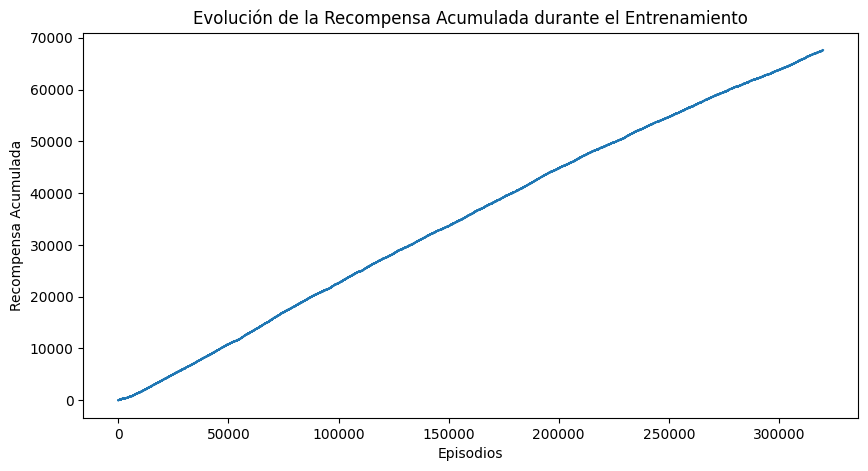

In [7]:
# Graficar las recompensas acumuladas
plt.figure(figsize=(10, 5))
plt.plot(rewards_df['cumulative_reward'])
plt.xlabel('Episodios')
plt.ylabel('Recompensa Acumulada')
plt.title('Evolución de la Recompensa Acumulada durante el Entrenamiento')
plt.show()

In [8]:
import pandas as pd

# Visualizar la tabla de la función de valor
funcion_de_valor = sorted(agent1.value_function.items(), key=lambda kv: kv[1], reverse=True)
tabla = pd.DataFrame({'estado': [x[0] for x in funcion_de_valor], 'valor': [x[1] for x in funcion_de_valor]})

# Mostrar la tabla
tabla

,estado,valor
0,[[ 0. 0. 0. 0. 0. 0. 0.]\n [ 0. 0. 0. ...,1.0
1,[[ 0. 0. 0. 0. 0. 0. 0.]\n [ 0. 0. 0. ...,1.0
2,[[ 0. 0. 0. 0. 0. 0. 0.]\n [ 0. 0. 0. ...,1.0
3,[[ 0. 0. 0. 0. 0. 0. 0.]\n [ 0. 0. 0. ...,1.0
4,[[ 0. 0. 0. 0. 0. 0. 0.]\n [ 0. 0. 0. ...,1.0
...,...,...
2954680,[[ 0. 0. 0. 0. 0. 0. 0.]\n [ 0. 0. 0. ...,0.0
2954681,[[ 0. 0. 0. 0. 0. 0. 0.]\n [ 0. 0. 0. ...,0.0
2954682,[[ 0. 0. 0. 0. 0. 0. 0.]\n [ 0. 0. 0. ...,0.0
2954683,[[ 0. 0. 0. 0. 0. 0. 0.]\n [ 0. 0. 0. ...,0.0


In [9]:
import pickle

with open('agente.pickle', 'wb') as handle:
    pickle.dump(agent1.value_function, handle, protocol=pickle.HIGHEST_PROTOCOL)